In [1]:
# Initializing:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt

# Regex module is needed to search for substrings later on:
import re

# Needed to make plots display at a decent size:
plt.rcdefaults()

# Gini Coefficient & GDP data were downloaded from:
#  * https://ourworldindata.org/income-inequality#high-income-countries-tend-to-have-lower-inequality
#  * https://ourworldindata.org/economic-growth#gdp-per-capita-over-the-long-run

# Github URLs where I uploaded the data files; using this instead of the ourworldindata.org
# website, as the latter does not provide direct URLS to download the two CSV files,
# only JavaScript(?) download buttons; so Github raw files is a good alternative:

URL_GI = "https://github.com/MikeSchotten/Module_6_Assignment/raw/main/economic-inequality-gini-index.csv"
URL_GDP = "https://github.com/MikeSchotten/Module_6_Assignment/raw/main/gdp-per-capita-maddison-2020.csv"

# For reference:  Gini Coefficient methodology is explained here:
# https://ourworldindata.org/income-inequality#metrics-and-definitions


# Read in the data CSV files.  The encoding="unicode-escape" addition
# is needed to prevent an error in pandas (UTF-8 had problems with some data cells):
df_GI_raw = pd.read_csv(URL_GI, encoding="unicode_escape")
df_GDP_raw = pd.read_csv(URL_GDP, encoding="unicode_escape")

display(df_GI_raw.head())
display(df_GDP_raw.head())


,Entity,Code,Year,Gini coefficient
0,Albania,ALB,1996,0.270103
1,Albania,ALB,2002,0.317390
2,Albania,ALB,2005,0.305957
3,Albania,ALB,2008,0.299847
4,Albania,ALB,2012,0.289605


,Entity,Code,Year,GDP per capita,417485-annotations
0,Afghanistan,AFG,1950,1156.0,NaN
1,Afghanistan,AFG,1951,1170.0,NaN
2,Afghanistan,AFG,1952,1189.0,NaN
3,Afghanistan,AFG,1953,1240.0,NaN
4,Afghanistan,AFG,1954,1245.0,NaN


In [2]:
# NOTE TO WINC INSTRUCTORS:
# 
# I'm guessing that the following code doesn't work if you haven't 
# installed the itables library on your machine.  If so, you can simply 
# delete this cell or comment it out.
# ----------------------------------------------------------------------


# Using & initializing itables library:
# 
# This has similar functionality as G. Colabs Data Tables,
# and needs to have been installed beforehand.
# Documentation: https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=False)
# init_notebook_mode(all_interactive=True)

import itables.options as opt
opt.order = []  # No sorting by default; so display DF exactly as the original CSV file
opt.classes = ["display", "cell-border"]   # Show borders between table cells
opt.lengthMenu = [5, 7, 10, 20, 50, 100, 200]  # Customize menu with nr. of rows shown per page
opt.column_filters = "footer"  # Show filters at bottom of table

# Set column width; if you don't do this, the column headers and data become illegible.
opt.columnDefs = [{"width": "75px", "targets": "_all"}]

# Set option to display ALL columns 
# (default = pd.get_option('display.max_columns') = 20 columns max):
opt.maxColumns = 0

# # NOTE: You can turn on the following lines with maxBytes=True
# # to show ALL data in one large table (but note, can be very heavy 
# # on Notebook, so recommended to turn off again after use):
show(
    df_GI_raw,
    scrolly="1000px",
    maxBytes=0
)


<IPython.core.display.Javascript object>

In [3]:
# CLEANING UP 'df_GI_raw'
# PART 1: INSPECTION
# -----------------------------------

# Find 181 entries with 'Code' = nan:
df_GI_Code_nan = df_GI_raw.loc[df_GI_raw['Code'].isnull()]

# Find the unique country names for those in 'Entity' column:
df_GI_Entities_w_Code_nan = pd.Series(df_GI_Code_nan.loc[:, 'Entity'].unique())

# And their frequency:
df_GI_Entities_w_Code_nan_freq = df_GI_Code_nan.loc[:, 'Entity'].value_counts()

# Check results:
# df_GI_Code_nan
# print(df_GI_Entities_w_Code_nan)
print('In the Gini Index file, the following country names (column "Entity") have \n' \
      'a missing value in the country "Code" column + their nr. of rows:\n')
print(df_GI_Entities_w_Code_nan_freq)


In the Gini Index file, the following country names (column "Entity") have 
a missing value in the country "Code" column + their nr. of rows:

Argentina - urban               32
Indonesia - rural               29
Indonesia - urban               29
China - rural                   20
China - urban                   20
Uruguay - urban                 13
India - rural                   12
India - urban                   12
Colombia - urban                 4
Ecuador - urban                  3
Bolivia - urban                  2
Ethiopia - rural                 1
Honduras - urban                 1
Micronesia (country) - urban     1
Rwanda - rural                   1
Suriname - urban                 1
Name: Entity, dtype: int64


In [4]:
# CLEANING UP 'df_GI_raw'
# PART 2: ASSUMPTIONS & RATIONALE
# -----------------------------------

# Manual inspection of 'df_GI_raw' showed that
# only China, Indonesia & India each have triple
# Gini Coefficient (or "Gini Index" = GI) measurements
# for each measurement year:
#   1) for the country as a whole - with the respective country code in "Code"
#   2) an "- urban" GI measurement - with "Code" nan
#   3) a "- rural" GI measurement - also with "Code" nan
# 
# Therefore, the urban and rural GI measurement rows can be
# discarded for those three countries, and the "whole country"
# GI can be used for the correlation with GDP for those years.
# 
# --------------------------------------------------------------------------
#      [An observation however: sorting by years manually (in itables)
# and then filtering on country showed that for China, both the rural
# and urban GIs were LOWER than the GI for the whole country (for each
# measurement year), while for Indonesia and India the whole country
# GI was always in between the rural and urban values, which makes
# much more sense.
# 
# Another observation is that the rural GIs for China were HIGHER
# than the urban GIs for older years, which is inconsistent with
# both India and Indonesia: there the urban GI is always higher than
# than the rural GI for each year, which also makes more sense.
# And on top of that, for more recent years in China, the urban GI
# is ALSO higher than the rural GI (in contrast to the older years,
# thus flipping the trend).
# 
# All in all, this makes me not trust the China rural and urban GI
# data.  Likely different methodologies were used for those data,
# this caution can also be read on https://ourworldindata.org website at
# https://ourworldindata.org/income-inequality#world-bank-povcal-net
# (the part in Italic).
# 
# So for China I'm just going to assume that the whole country GI is 
# the "correct" one (or at least the official one) and ignore the artefact
# of the rural/urban GIs both being lower than the whole country GI.]
# --------------------------------------------------------------------------
# 
# 
# For the remaining 10 countries above (all of them only with an "urban",
# GI, except for Rwanda with a "rural" GI), these mostly concerned
# older measurement years (except for Argentina, where it concerned
# all years), and did NOT have a separate GI for the
# country as a whole for those years; and for 12 of them,
# - except for Argentina - they did have a GI for the country as whole
# (with respective country code) for more recent years,
# while not having a separate rural or urban GI
# for those more recent years.

# Therefore, for those 10 countries I assumed that the "urban"
# or "rural" designations for older years simply represent the
# GI measurement for the country as a whole, and I replaced
# their "Entity" and "Code" names accordingly.  So those GI
# values WILL be used for the correlation with GDP.


In [5]:
# CLEANING UP 'df_GI_raw'
# PART 3: discarding rows for 3 countries
# -----------------------------------

# Delete rows with urban & rural GI values
# for China, India and Indonesia, and assign to
# new cleaned up 'df_GI'.
# 
# Note: use the .reset_index(drop=True) method to
# "forget" the row indices from 'df_GI_raw'
# and to prevent a new column with those old indices.

mask_Code_nan = df_GI_raw['Code'].isnull()
mask_3_countries = df_GI_raw['Entity'].str.contains('china|indonesia|india', case=False)
df_GI = df_GI_raw.loc[~(mask_Code_nan & mask_3_countries)].reset_index(drop=True)

# Check results:
# show(
#     df_GI,
#     scrolly="1000px",
#     maxBytes=0
# )

In [6]:
# CLEANING UP 'df_GI_raw'
# PART 4: modifying rows for 10 countries
# -----------------------------------

# Now clean up values 'Entity' and 'Code' columns
# for each of the ten remaining countries,
# one country at a time:
for country in df_GI_Entities_w_Code_nan:
    
    # Bcs. for China, India & Indonesia, the rows with urban & rural strings
    # have just been removed, exclude those 3 countries
    # from the list of 13 by using a regex search with inverse bool().
    # This is similar to the .str.contains() method in cell above
    # (but that is a pandas method and can't be used on simple
    # Python strings from a list, hence this alternative):
    if ~bool(re.search('china|indonesia|india', country, re.IGNORECASE)):
        
        # Remove the urban & rural substrings from country names,
        # by replacing them with empty substring:
        if 'urban' in country:
            country_short = country.replace(' - urban', '')
        elif 'rural' in country:
            country_short = country.replace(' - rural', '')
            
        # Find the country code in 'Code' column from other rows of this
        # country that do NOT have the urban & rural additions (and
        # hence do not have a NaN value in 'Code').
        # Only for Argentina and Suriname, there are no rows without
        # the ' - urban' addition, so add those code strings manually:
        if country_short == 'Argentina':
            code = 'ARG'
        elif country_short == 'Suriname':
            code = 'SUR'
        else:
            code = df_GI.loc[df_GI['Entity']==country_short].loc[:, 'Code'].head(1).squeeze()
        
        # Finally, substitute the long country name with the shortened name
        # and add the country code to the respective columns for the
        # df_GI rows of that country:
        df_GI.loc[df_GI['Entity']==country, ['Entity','Code']] = [country_short, code]

# Check results:
# show(
#     df_GI,
#     scrolly="1000px",
#     maxBytes=0
# )

In [7]:
# Now inspect the GDP data in itables:
# show(
#     df_GDP_raw,
#     scrolly="1000px",
#     maxBytes=0
# )

In [8]:
# CLEANING UP 'df_GDP_raw'
# PART 1: INSPECTION
# -----------------------------------

# Find 225 entries with 'Code' = nan:
df_GDP_Code_nan = df_GDP_raw.loc[df_GDP_raw['Code'].isnull()]

# Find the unique 'country' names for those in 'Entity' column:
df_GDP_Entities_w_Code_nan = pd.Series(df_GDP_Code_nan.loc[:, 'Entity'].unique())

# And their frequency:
df_GDP_Entities_w_Code_nan_freq = df_GDP_Code_nan.loc[:, 'Entity'].value_counts()

# Check results:
# df_GDP_Code_nan
# print(df_GDP_Entities_w_Code_nan)
print('In the GDP file, the following "country" names (actually mostly regions; column "Entity") \n' \
      'have a missing value in the country "Code" column + their nr. of rows:\n')
print(df_GDP_Entities_w_Code_nan_freq)


In the GDP file, the following "country" names (actually mostly regions; column "Entity") 
have a missing value in the country "Code" column + their nr. of rows:

Former Sudan                 69
Eastern Europe               23
Western Europe               23
Western Offshoots            21
Latin America                20
South and South-East Asia    19
East Asia                    17
Middle East                  17
Sub-Sahara Africa            16
Name: Entity, dtype: int64


In [9]:
# CLEANING UP 'df_GDP_raw'
# PART 2: modifying + discarding rows
# -----------------------------------

# For Sudan, manual inspection of 'df_GI' (in itables) showed
# that for the Gini Index file, there are rows for:
#   1) 'Sudan' - code SDN
#   2) 'South Sudan' - code SSD
# This reflects the recent break-up of the country in 2011.
# 
# For consistency (to enable the merge between the 2 DFs),
# modify the GDP DataFrame so that 'Former Sudan' (which
# refers to the entire country before the break-up) is 
# renamed to 'Sudan', and assign it country code SDN.
# 
# This is justifiable, bcs.the GDP file also does not contain
# any other rows with 'Sudan' or 'South Sudan', and spans the
# entire period 1950-2018 (while the official break-up happened
# in 2011, see https://en.wikipedia.org/wiki/Sudan ).
# And for the years 2011-2018, 'Former Sudan' likely refers to
# the official 'Sudan' part and not to the split-off 'South Sudan'.

df_GDP = df_GDP_raw.copy()
df_GDP.loc[df_GDP['Entity']=='Former Sudan', ['Entity','Code']] = ['Sudan', 'SDN']


# Delete the 156 remaining rows with 'Code' = nan 
# (namely 225 - 69 'Sudan' rows, which now have a country code).
# These are all the rows with region names in 'Entity', see above.
# 
# Note: use the .reset_index(drop=True) method to
# "forget" the row indices from 'df_GDP'
# and to prevent a new column with those old indices.
mask_GDP_Code_nan = df_GDP['Code'].isnull()
df_GDP = df_GDP.loc[~(mask_GDP_Code_nan)].reset_index(drop=True)


# Also delete column '417485-annotations';
# this only contained a string for the 'Western Offshoots' region, and now
# that the rows with regions have been removed, only NaN values.
df_GDP.drop(columns='417485-annotations', inplace=True)


# Check results:
# show(
#     df_GDP,
#     scrolly="1000px",
#     maxBytes=0
# )


In [10]:
# MERGING THE 2 DATAFRAMES

# Use pandas .merge() method using a double merge key:
# columns 'Code' and 'Year', because we only want to
# correlate GDP and GI data if they are from the same
# country and same year.
# 
# Using a double merge key is explained at:
#   1) https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#merging-on-a-combination-of-columns-and-index-levels
#   2) https://datagy.io/pandas-merge-concat/
# 
# An inner join should be used (= default for .merge() method)
# so that we only retain the rows where the country and year
# are the same for both DataFrames.  The validate parameter
# checks whether there is only a single row with that 
# country-year combination in either DataFrame, and will flag
# an error if not.

df_merged = pd.merge(
    left=df_GDP,
    right=df_GI,
    on=['Code', 'Year'],
    suffixes=('_GDP', '_GI'),
    validate='one_to_one'
)

# Sanity check that 'Entity_GDP' and 'Entity_GI'
# of merged items are the same:
df_merged['Same_country_check'] = df_merged['Entity_GDP']==df_merged['Entity_GI']

sanity_check = not(False in set(df_merged['Same_country_check']))

print('Sanity check: do all the merged rows have the same country' \
      '\nname in the "Entity_GDP" and "Entity_GI" columns?' \
      '\n(should be True if merge was done correctly)' \
      f'\n\nThe answer is: {sanity_check}')

# Check result:
# show(
#     df_merged,
#     scrolly="1000px",
#     maxBytes=0
# )



Sanity check: do all the merged rows have the same country
name in the "Entity_GDP" and "Entity_GI" columns?
(should be True if merge was done correctly)

The answer is: True


In [11]:
# CLEANING UP 'df_merged'

# Because the sanity check showed that the merge was
# done correctly, clean up some duplicate columns in df_merge:

df_merged.drop(columns=['Entity_GI', 'Same_country_check'], inplace=True)
df_merged.rename(columns={'Entity_GDP': 'Entity'})

# Check result:
# show(
#     df_merged,
#     scrolly="1000px",
#     maxBytes=0
# )


,Entity,Code,Year,GDP per capita,Gini coefficient
0,Albania,ALB,1996,3965.685303,0.270103
1,Albania,ALB,2002,5608.962402,0.317390
2,Albania,ALB,2005,6858.466797,0.305957
3,Albania,ALB,2008,8522.129883,0.299847
4,Albania,ALB,2012,9592.000000,0.289605
...,...,...,...,...,...
1862,Zambia,ZMB,2006,2133.593994,0.546175
1863,Zambia,ZMB,2010,3032.067871,0.556215
1864,Zambia,ZMB,2015,3478.000000,0.571361
1865,Zimbabwe,ZWE,2011,1515.000000,0.431536


In [12]:
# LINEAR REGRESSION HELPER FUNCTIONS:


# First define the linear regression function:
# Calculate the linear regression line, incl. the R^2 value = Coefficient of Determination
# (Or more accurately: the Pearson Correlation Coefficient (= R) squared).
# From: https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
# I used the code and answer from 'russian_spy', which has a good explanation of R^2 vs. r^2.
#
# # Alternative method to find R^2 that yields the same result:
# import scipy
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y1, ffit1)
# R_squared = r_value ** 2


# Helper function to get the linear regression line equation and R^2 value:

def linear_regression(x, y): 
    try:
        # Divide the x-values (GDP in constant 2011 international $-equivalent)
        # by 1000 to get the correlation results (and line slope m)
        # for the GDP measured in $1000 units [$K].
        x = x / 1000
        
        # The '1' indicates that this is linear regression, i.e. a 1st degree polynomial:
        coefs = np.polynomial.polynomial.polyfit(x, y, 1)
        ffit = np.poly1d(coefs)
        line_values = np.polynomial.polynomial.polyval(x, coefs)
        
        # Slope of regression line, m:
        m = ffit[0]
        # Intercept of regression line, b:
        b = ffit[1]
        
        # Create string for line equation, dependent on value of slope m
        # (either negative or positive).
        if m < 0:
            eq = 'Gini Coeff. = {} - {} * GDP [in $K]'.format(round(b, 2), round(abs(m), 4))
        else:
            eq = 'Gini Coeff. = {} + {} * GDP [in $K]'.format(round(b, 2), round(m, 4))
            
        # R value as string:
        r = 'R = {}'.format(round(np.corrcoef(x, y)[0, 1], 12))
        # R^2 value as string:
        rsquared = r'R$^2$ = {}'.format(round(np.corrcoef(x, y)[0, 1]**2, 3))
        
        nr = f'N = {len(x)}'
        
    except ValueError as error:
        print(f"Could not plot linear regression line because: {error}")
        
    return r, rsquared, eq, nr, m, b, line_values


# Helper function to add regression line + text box to a figure:

def add_regression_lines(x, y, ax):
    # Get correlation values from previous helper function:
    r, rsq, eq, nr, m, b, line_values = linear_regression(x, y)
    
    # Plot linear regression line in red:
    ax.plot(x, line_values, c='red')
    scaling_ax = ax.axis()
    
    # Create text box with the regression line
    # and Pearson correlation results:
    text = f'Linear regression line:\n{rsq}  /  {nr}\n{eq}'
    ax.text(0.023 * scaling_ax[1], 0.837 * scaling_ax[3], text, c='red', weight='bold',
             size='medium', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})



In [13]:
# Use the above functions to calculate linear 
# correlation between GDP and Gini Coefficient
# and display results:

x_GDP = df_merged['GDP per capita']
y_GI = df_merged['Gini coefficient']

# Check results:
linear_regression(x_GDP, y_GI)


('R = -0.432824633569',
 'R$^2$ = 0.187',
 'Gini Coeff. = 0.43 - 0.0026 * GDP [in $K]',
 'N = 1867',
 -0.0026403670481723583,
 0.42502621639662297,
 0       0.414555
 1       0.410216
 2       0.406917
 3       0.402525
 4       0.399700
           ...   
 1862    0.419393
 1863    0.417020
 1864    0.415843
 1865    0.421026
 1866    0.420848
 Name: GDP per capita, Length: 1867, dtype: float64)

In [14]:
# Import pingouin library correlation module,
# to double-check the results above;
# 
# This module also calculates the 95% Confidence
# Interval for the Pearson Correlation Coefficient R
# and the p-value,thus showing whether the
# correlation is statistically significant 
# (generally accepted to be the case
# if p < 0.05 or p < 0.01).
# 
# This code was borrowed from the example Notebook underneath 
# the Peter's Statistics video on the Winc page of this
# assignment, explaining the Pearson Correlation: https://bit.ly/3l9xbjF 

from pingouin import corr

summary = corr(x_GDP, y_GI)

# Check results:
summary


,n,r,CI95%,p-val,BF10,power
pearson,1867,-0.432825,"[-0.47, -0.4]",4.175177e-86,2.405e+82,1.0


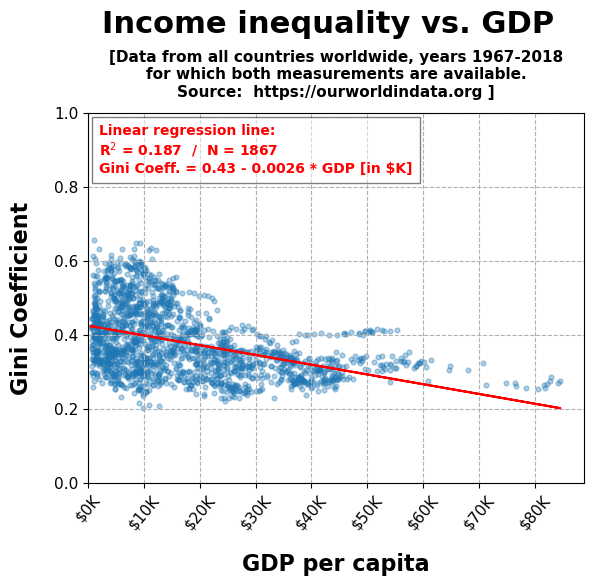

In [15]:
# PLOT GINI COEFFICIENT VS. GDP,
# INCL. LINEAR REGRESSION LINE:

fig, ax = plt.subplots()

plot_titles = [
    'Income inequality vs. GDP',
    '[Data from all countries worldwide, years 1967-2018' \
    '\nfor which both measurements are available.' \
    '\nSource:  https://ourworldindata.org ]'
]

# Helper function to set the GDP xtick string format to $K units.
# From:https://matplotlib.org/stable/tutorials/introductory/
#         lifecycle.html#sphx-glr-tutorials-introductory-lifecycle-py
def currency(x, pos):
    """The two arguments are the value and tick position"""
    if x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

ax.scatter(x_GDP, y_GI, s=12, alpha=0.35)
ax.set_xlabel('GDP per capita', weight='bold', fontsize=16, labelpad=15)
ax.set_ylabel('Gini Coefficient', weight='bold', fontsize=16, labelpad=15)
ax.grid(True, linestyle='--')

# Set title and subtitle:
plt.suptitle(plot_titles[0], weight='bold', y=1.095, fontsize=22)
plt.title(plot_titles[1], weight='bold', fontsize=11, pad=12)

# Set some properties of the x-tick and y-tick labels.
# See also https://e2eml.school/matplotlib_ticks.html
ax.tick_params(labelsize=11)
ax.xaxis.set_major_formatter(currency)
ax.tick_params(axis="x", labelrotation=50)

# Set the min and max values of the x-axis and y-axis.
# Note that Gini Coefficient is always between 0 (= no inequality)
# and 1 (= maximum inequality, i.e. 1 person has all the wealth).
ax.set_xlim(0,)
ax.set_ylim(0, 1)

# Helper function from previous cell to add linear regression line
# and text box, both in red.  Note that this function
# calls the other helper function 'linear_regression'
# to calculate these values:
add_regression_lines(x_GDP, y_GI, ax)

plt.show()


<div class="alert alert-block alert-success">

<h1>Conclusions</h1>

<b><h3>Answer to Question:<br>Is there a relation between a country's Gross Domestrict Product (GDP) and its income inequality?</h3></b>
- The plot above shows that, <code style="background:yellow"><b>yes, there is an inverse relation between the GDP per capita of a country in a certain year and the so-called Gini Coefficient</b></code>, which is a measure of income inequality (also called Gini Index = GI), measured in the same country and year.<br><br>
- In other words: the higher the GDP, the smaller the income inequality tends to be.<br><br>
- This inverse linear correlation is relatively weak, with a <code style="background:yellow"><b>R^2 = 0.19</b></code> (= Coefficient of Determination, or Pearson Correlation Coefficient R squared).<br><br>
- Nevertheless, this relatively weak inverse linear correlation is <code style="background:yellow"><b>statistically very significant</b></code>: the calculated p-value was 4.175177e-86. So the probability p that there is NO correlation between GDP and GI whatsoever is much smaller than 0.1%:  <code style="background:yellow"><b>p< 0.001</b></code>.

<b><h3>Notes & caveats:</h3></b>
- Each data point represents one GDP-GI measurement combination, for a single year in a single country (with multiple year measurements per country, irregular from the period 1967-2018, for most countries worldwide).<br><br>
- The Gini Coefficient is calculated as <b>a value between 0 and 1</b>, with 0 being no inequality (i.e., all wealth in a country is equally distributed among everyone) and 1 being the maximum inequality (i.e., one person owns all the wealth in a country).  See here for how it's calculated: https://ourworldindata.org/income-inequality#metrics-and-definitions<br><br>
- Strictly speaking, because of the way the <b>Gini Coefficient</b> is calculated (that is, in a non-linear way), <b>it’s a so-called ordinal variable</b>.  Similar to for example the Richter scale to measure earthquakes, which is logarithmic and also ordinal. This means that e.g. the interval between GI=0.3 and 0.4 does not represent the same income inequality difference as the interval between GI=0.4 and 0.5.  See here for an explanation: https://www.youtube.com/watch?v=N74MeeY5KZw&list=PL8XPveTjwRbTPxnAvhXVNh5DHPe5f8iSe&index=4<br><br>
- Because the GI is an ordinal variable and not a so-called “scale” or numerical variable (while GDP is a scale variable), <b>strictly speaking we cannot do a Pearson correlation on GDP vs. GI</b>.  However, for this exercise I ignored this, as the GI is still somewhat like a scale variable.  We can only do a Pearson correlation analysis on two scale variables.<br><br>
- In this assignment <b>I only looked at a linear correlation</b>, and not at a higher order (= polynomial) correlation.  Looking at the chart, it looks like a polynomial inverse relation might give a slightly better fit.<br><br>

</div>